In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
from tensorflow import keras


## LSE ID: 202347597
##Candidate number: 27515

# Helpful functions
Here are some functions which will be useful for the assignment.

In [3]:
# Plot the confusion matrix of the classification task

# actual: true labels, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# predicted: predictions, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# labels: list of strings with the name of the classes


def plot_confusion_matrix(actual, predicted, labels):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(8, 8)})
  sns.set(font_scale=1.4)
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('Actual class')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [4]:
# Per class, extract the indexes of correctly and uncorrectly predicted data points

# model: name of the model
# x_train: training data
# ind_class: for which class do you want to observe the wrong predictions? Give it as a numeric value, not a string

def ind_correct_uncorrect(model, x_train, ind_class):
  ind = np.where(np.argmax(y_train, axis=1) == ind_class)[0]
  ind_correct = []
  ind_uncorrect = []
  preds = model.predict(x_train[ind], verbose=0)
  for i in range(len(ind)):
    if np.argmax(preds[i]) == np.argmax(y_train[ind[i]]):
      ind_correct.append(ind[i])
    else:
      ind_uncorrect.append(ind[i])
  return ind_correct, ind_uncorrect

In [5]:
# Per class, plot a given number (i_max * j_max) of spectrograms

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind_plot: indexes of the data points that you want to plot

def plot_spectrograms(i_max, j_max, x_train, ind_plot):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind = ind_plot[i*j_max+j]
      axs[i, j].imshow(x_train[ind])
      axs[i, j].grid(False)
  fig.show()

In [6]:
# Per class, print the predictions of those points that were wrongly classified

# model: name of the model
# x_train: training data
# y_train: training labels, one hot encoded
# ind_wrong: indexes of wrongly predicted points
# ind_class: for which class do you want to observe the wrong predictions? Give it as a numeric value, not a string
# labels: list of strings with the name of the classes

def print_wrong_prediction(model, x_train, y_train, ind_wrong, ind_class, labels):
  print('Wrongly predicted points for true class', labels[ind_class])
  for i in range(len(ind_wrong)):
    preds = model.predict(tf.expand_dims(x_train[ind_wrong[i]], axis=0), verbose=0)
    if np.argmax(preds) != np.argmax(y_train[ind_wrong[i]]):
      print('predicted class is', labels[np.argmax(preds)])

In [7]:
# Compute Grad-CAM heatmap for a given data point and a hidden layer

# imag_array: image (represented as array) on which the heatmap will be produced
# model: name of the model
# layer_name: name of the layer on which the heatmap will be computed

def make_gradcam_heatmap(img_array, model, layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [8]:
# Per class, plot a given number (i_max * j_max) of Grad-CAM heatmaps

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind: indexes of the wrongly predicted data for that class
# model: name of model
# layer_name: name of layer on which to compute Grad-CAM

def plot_gradcam_spectrogram(i_max, j_max, x_train, ind, model, layer_name):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind_ = ind[i*j_max+j]
      heatmap = make_gradcam_heatmap(tf.expand_dims(x_train[ind_], axis=0), model, layer_name)
      axs[i, j].matshow(heatmap)
      axs[i, j].grid(False)
  fig.show()

# Download data
After having loaded them to the Google Drive associated to your colab account (you can also load them manually, in that case modify the path accordingly).

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
npzfile = np.load('./drive/MyDrive/ST456/ST456_WT2024_data_assign1.npz')

# features
x_train = npzfile['x_train']
x_val = npzfile['x_val']
x_test = npzfile['x_test']

# one hot encoded labels
y_train = npzfile['y_train']
y_val = npzfile['y_val']
y_test = npzfile['y_test']

# numerical labels
y_train_num = npzfile['y_train_num']
y_val_num = npzfile['y_val_num']
y_test_num = npzfile['y_test_num']

In [11]:
# the classes correspond to 4 music genres, in this order
classes = ['classical', 'disco', 'metal', 'rock']

In [12]:
x_train.shape[0] + x_val.shape[0]+x_test.shape[0]

6000

# P1

The goal is to train a CNN-based classifier on the Mel spectrograms to predict the corresponding music genres. Implement the following CNN architecture:

- a 2D convolutional layer with 4 channels of squared filters of size 5, padding, default stride, ReLU activation function and default weight and bias initialisations.
- a 2D max pooling layer with size 2 and stride 2.
- a 2D convolutional layer with 8 channels of squared filters of size 5, padding, default stride, ReLU activation function and default weight and bias initialisations.
- a 2D max pooling layer with size 2 and stride 2.
- a 2D convolutional layer with 16 channels of squared filters of size 5, padding, default stride, ReLU activation function and default weight and bias initialisations.
- a 2D max pooling layer with size 2 and stride 2.
- a layer transforming the output filters to a 1D vector.
- a dense layer made of 50 neurons, ReLU activation and L2 regularisation with - a penalty of 0.01
- an output layer with the required number of neurons and activation function.
- Compile the model using an appropriate evaluation metric and loss function. To optimise, use the mini-batch stochastic gradient descent algorithm with batch size 32. Train the model for 20 epochs.

In [68]:
x_train[0].shape
# this determines the input shape

(80, 80, 1)

In [69]:
# Model fit. Remember to use the CPU runtime and set the seed before:
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()



# **Qeustion 1:How many parameters does the model train? Before performing the training, do you expect this model to overfit? Which aspects would influence the overfitting (or not) of this model?**

* **Parameters for the first convolutional layer** = $(5*5*1 +1)*4 = 104$
    - 5*5 - filters
    - 1 - number of input channels
    - 4 - number of output channels
    - when i plus 1 - because of bias term

* **Parameters for the second convolutional layer** = $(5*5*4 +1)*8 = 808$
    - 5*5 - filters
    - 4 - number of input channels
    - 8 - number of output channels
    - 1 - bias
  
* **Parameters for the third convolutional layer** = $(5*5*8 +1)*16 = 3216$
    - 5*5 - filters
    - 8 - number of input channels
    - 16 - number of output channels
    - 1 - bias

After first convolutional and first pooling the size: $((80-5+2*2)/1+1)/2$ = 40x40
After second convolutional and second pooling the size: $((40-5+2*2)/1+1)/2$ = 20x20
After third convolutional and third pooling the size: $((20-5+2*2)/1+1)/2$ = 10x10

* **Flattening** - $10*10*16$ as third convolutional layer produced 16 channels. SO total features to be put into Dense layer are 1600
* **Dense Layer** - $(1600+1)*50 = 80050$ because we adjusted for bias and there are 50 neurons
* output layer contains info about the number of classes: $50*4+4=204$

* 104 + 808 + 3216 + 80050 + 204 = 84382

**Overfitting rationale**

L2 regularization in the dense layer helps penalize large weights - solution for overfitting

Potential overload with parameters as the number of data points is small in comparison to the number of parameters, I assume that model may learn the data. I will look at the plots of loss and accuracy on train and validation data to understand whether model has ability to generalize of it just learns data.

Model may be learning noize or not that important signals from data if it does not account for the structure - but here the shapes of filters are squared which means paying same attention to frequency and to time simultaneously which may also work worse in terms of generalization.


Usually there might be a problem of class imbalance, which is why overfitting may take place. Ive decided to check for this. If some of the genres represented more, the model might learn them, memorize them and then classify most of genres as if it is that one most frequently represented in training set.


In [70]:
import numpy as np

def check_imbalance(y):
    class_counts = np.sum(y, axis=0)  # Sum across rows to get the count of each class
    total_samples = y.shape[0]
    class_proportions = class_counts / total_samples
    return class_counts, class_proportions

# Train
train_counts, train_proportions = check_imbalance(y_train)
print("Training Set:")
print("Count:", train_counts)
print("Proportion:", train_proportions)

# Test
test_counts, test_proportions = check_imbalance(y_test)
print("\nTest Set:")
print("Counts:", test_counts)
print("Proportion:", test_proportions)

# Val
val_counts, val_proportions = check_imbalance(y_val)
print("\nValidation Set:")
print("Count:", val_counts)
print("Proportion:", val_proportions)

print('In conclusion, I can say that the classes are represented in quite good balance throughout all the subsets!')

Training Set:
Count: [986. 987. 995. 991.]
Proportion: [0.2490528  0.24930538 0.25132608 0.25031573]

Test Set:
Counts: [296. 265. 287. 324.]
Proportion: [0.25255972 0.22610922 0.24488054 0.2764505 ]

Validation Set:
Count: [218. 248. 218. 185.]
Proportion: [0.25086308 0.2853855  0.25086308 0.21288837]
In conclusion, I can say that the classes are represented in quite good balance throughout all the subsets!


Another indicator of overfitting can be seen through the gap between the training and validation/test datasets. If model would perform well on the training data but far more worse on the validation/test data, I would think it is overfitted. Or if the loss is decresing for training set only and validation set remains with either high loss or if the loss starts increasing again after some iterations

In [71]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(4, (5, 5), input_shape=(80, 80,1), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Conv2D(8, (5, 5), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model.add(tf.keras.layers.Dense(4,  activation = 'softmax')) # n classes - the final number of  - OUTPUT LAYER !!!!!!!!!

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 80, 80, 4)         104       
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 40, 40, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_57 (Conv2D)          (None, 40, 40, 8)         808       
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 20, 20, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 20, 20, 16)        3216      
                                                                 
 max_pooling2d_63 (MaxPooli  (None, 10, 10, 16)       

In [72]:
# compile and run
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data = (x_val, y_val))

Epoch 1/20
124/124 [==============================] - 29s 226ms/step - loss: 2.0292 - accuracy: 0.4971 - val_loss: 2.0783 - val_accuracy: 0.4925
Epoch 2/20
124/124 [==============================] - 19s 156ms/step - loss: 1.6543 - accuracy: 0.6908 - val_loss: 1.6249 - val_accuracy: 0.6858
Epoch 3/20
124/124 [==============================] - 21s 169ms/step - loss: 1.5079 - accuracy: 0.7300 - val_loss: 1.4574 - val_accuracy: 0.7296
Epoch 4/20
124/124 [==============================] - 20s 162ms/step - loss: 1.4307 - accuracy: 0.7487 - val_loss: 1.3984 - val_accuracy: 0.7560
Epoch 5/20
124/124 [==============================] - 21s 173ms/step - loss: 1.3398 - accuracy: 0.7749 - val_loss: 1.3236 - val_accuracy: 0.7756
Epoch 6/20
124/124 [==============================] - 24s 192ms/step - loss: 1.2574 - accuracy: 0.7921 - val_loss: 1.2940 - val_accuracy: 0.7699
Epoch 7/20
124/124 [==============================] - 26s 214ms/step - loss: 1.2096 - accuracy: 0.7969 - val_loss: 1.1932 - val_ac

In [73]:
# checkpoint the model at its final state
model.save_weights('./drive/MyDrive/ST456/checkpoints')

# 2. Plot the loss function and the accuracy per epoch for the train and validation sets

Text(0.5, 0.98, '2 x (CNN + MaxPooling)')

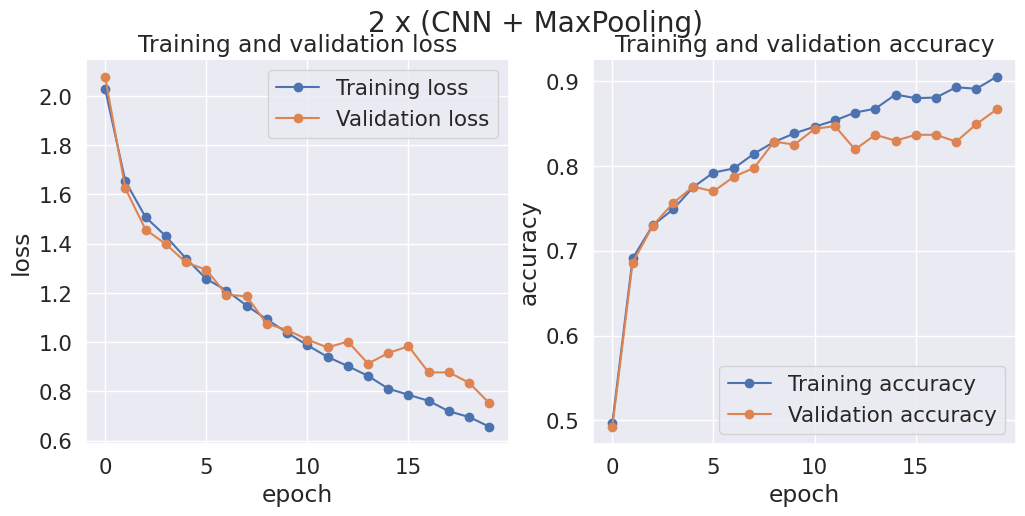

In [74]:
# Plot the loss function and the accuracy per epoch for the train and validation sets
# training and validation loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history3.history['loss'],'-o', label='Training loss')
ax1.plot(history3.history['val_loss'],'-o', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
ax2.plot(history3.history['accuracy'],'-o', label='Training accuracy')
ax2.plot(history3.history['val_accuracy'],'-o', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')
f.suptitle('2 x (CNN + MaxPooling)')

**Overfitting rationale**

The training loss is permanently decreasing - model does learn something. The validation loss also decreases, but at some iterations closer to the end it starts to fluctuate, showing higher values but then decreases. This is suspicious, I would rather say the model might have a very slight risk of overmemorizing the training data. I would try either heavier regularization or maybe checking dropout layers.

The training accuracy is increasing over epochs, so that the model really learns. The validation accuracy also goes up and follows the training accuracy  without drastic decreasing (though again there is a moment after many epochs, when the accuracy started showing values lower than during previous steps, which means that the model could have started overfitting to the training set)

From these observations, it doesn't appear that the model is overfitting very much, it has a generalizing ability, it doesn't just memorize the training set, though i would be a little sceptic and try my model with more penalizing.

 In this case, both the training and validation metrics are improving in tandem  with minor fluctuations which is OK, which suggests that the model is learning rather than memorizing the training data.

# 3. Which accuracy do you obtain on the test set?


In [75]:
#Which accuracy do you obtain on the test set?

# evaluate test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]
# print test accuracy
print('Test accuracy %.2f%%' % accuracy)

Test accuracy 87.37%


# 4. Using the function `plot_confusion_matrix` plot the confusion matrices of the classification task on the train set and test set. What do you observe from this metric? Which classes display more correct predictions? And wrong?

In [76]:
#need to do predictions first
predictions = model.predict(x_test)


37/37 [==============================] - 2s 47ms/step


In [77]:
original_categorical = np.argmax(y_test, axis=1)
original_categorical
preds = np.argmax(predictions, axis=1)
preds

array([1, 3, 3, ..., 2, 0, 3])

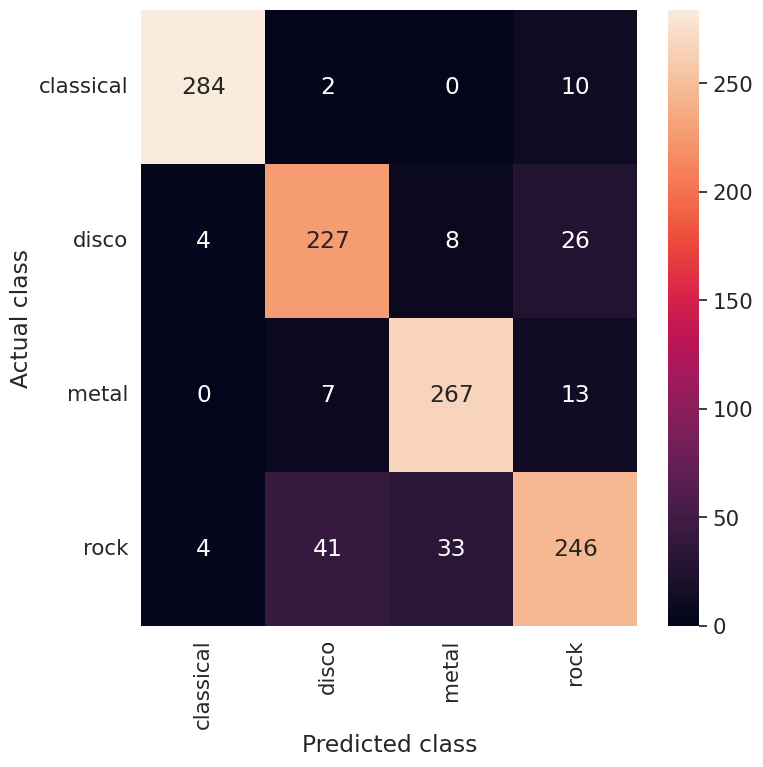

In [78]:
plot_confusion_matrix(original_categorical, preds , classes)

Description

 **Classical**:

- True Positives (TP): 284 correctly predicted
- False Positives (FP): 8 (4 - disco, 4-rock)
- False Negatives (FN): 12 (2 - disco, 10 - rock, though correct is classical)
 **Disco**:

- TP: 227 correctly predicted
- FP: 50 (2 - classical, 7 - metal, 41 - rock)
- FN: 38 (4 - classical, 8 - metal - 26 - rock)
(Rock and disco both cover quiet rhythmic melodies and are alike for the model)

 **Metal**:

- TP: 267 instances correctly predicted as metal.
- FP: 41 (8 - disco, 33 - rock)
- FN: 20 (0 - classical, 7 - disco and 13 - rock)

 **Rock**:

- TP: 246 instances correctly predicted as rock.
- FP: 49 (10 - classical, 26 - disco, 13 - metal)
- FN: 78 (4 - classical, 41- disco, 33 - metal)
Again proves the idea that rock is difficult to classify from other genres.

Observations:

The diagonal elements represent the number of correct predictions for each class, and they are the highest numbers so that the model does good work. High TP and low FP and FN shows model in confident.

Classical music is the genre with the highest number of right predictions! with little misclassifications, so that model knows how to identify this genre (as we are checking on test set and model didn't see this when trainin)


Disco and metal show moderate number of misclassifications but still have a high number of correct preds.

**Rock is difficult! to classify correctly. Both False Positive and False Negative are quite high in comparison to other genres. Audio characteristics of rock tend to be similar to disco which is seen in FP and FN numbers for certainly this genre. I suppose the model may learn something more out of this data. SO that I will create a new architecture in task 2 to solve this issue as well.**

124/124 [==============================] - 7s 53ms/step


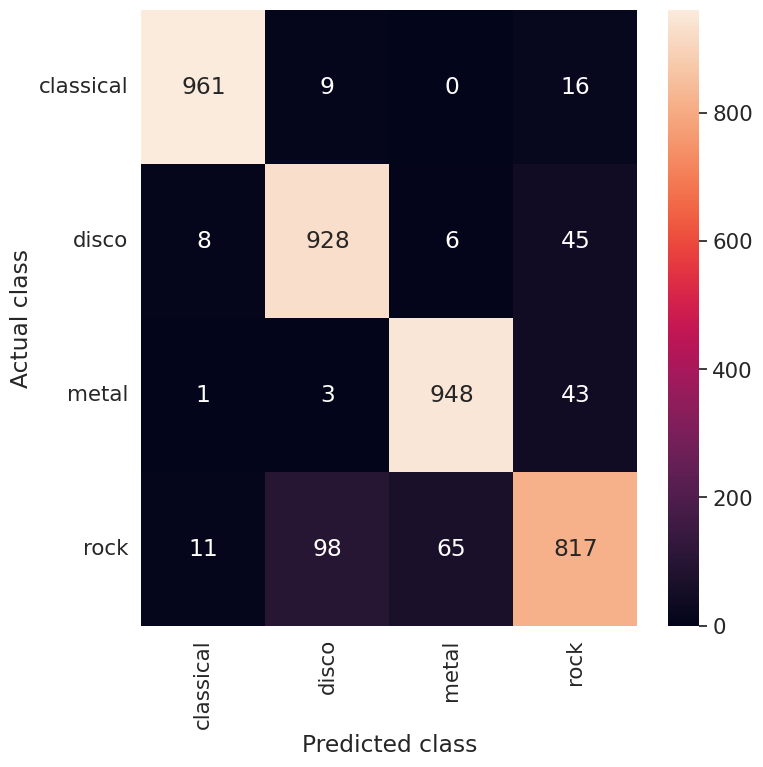

In [79]:
pred_train = model.predict(x_train)
plot_confusion_matrix(np.argmax(y_train, axis=1), np.argmax(pred_train, axis=1) , classes)


This confusion matrix is for train set

- **Classical:**
  - True Positives (TP): 961 correctly predicted
  - False Positives (FP): 20 (8 - disco, 1 - metal, 11 - rock)
  - False Negatives (FN): 25 (9 - disco, 16 - rock)

- **Disco:**
  - TP: 928  correctly predicted
  - FP: 110 (98 - rock, 3 - metal, 9 - classic)
  - FN: 59 (8 - classical, 6 - metal, 45  -rock)

- **Metal:**
  - TP: 948  correctly predicted
  - FP: 71 (6 - disco, 65 - rock)
  - FN: 47 (1 - classical, 3 - disco, 43 - rock)

- **Rock:**
  - TP: 817 correctly predicted
  - FP: 104 (16 - classical, 45 - disco, 43 - metal)
  - FN: 174 (11 - сclassical, 98 disco, 65 metal)

**Conclusion:**

- Model is training and learning as the diagonal points are high.

- Not only on the test confusion matrix but on the train as well - the model could not deal with rock genre well because we see quite high (in comparison to other genres) numbers for FP anf FN for this particular genre.

- Classical, disco, and metal genres have high TP rates and quite low FP and FN , so model is good at classifying these genres (better than for rock anyway).

Strategies to improve the model's performance:
- further feature engineering
- data augmentation
- specific architecture

Also may be implemented
- Precision (for a class) = TP / (TP + FP)
- Recall (for a class) = TP / (TP + FN)
- F1-Score (for a class) = 2 * (Precision * Recall) / (Precision + Recall)

# 5. Using the function `ind_correct_uncorrect` extract the indexes of the training data that were predicted correctly and incorrectly, per each class. For each music genre, perform the following steps:
   - Using the function `plot_spectrograms` plot the 12 mel spectrograms of the first 6 data points which were predicted correctly and the first 6 which were predicted wrongly. Do you observe some differences among music genres?
   - Using the function `print_wrong_prediction` print the predicted classes of the first 6 data points which were predicted wrongly.
   - Using the Grad-CAM method, implemented in the function `plot_gradcam_spectrogram`, print the heatmaps of the last pooling layer for the same 12 extracts (6 correct + 6 wrong). Comment on the heatmaps obtained. Do you observe differences among the heatmaps of different music genres? Can you understand why the model got some predictions wrong?

In [80]:
results = {}

for i in [0,1, 2, 3]:
    correct = ind_correct_uncorrect(model, x_train, i)[0]
    incorrect = ind_correct_uncorrect(model, x_train, i)[1]
    results[f'pred_{i}_correct'] = correct
    results[f'pred_{i}_incorrect'] = incorrect


#### Class_______________________classical______________________________________________

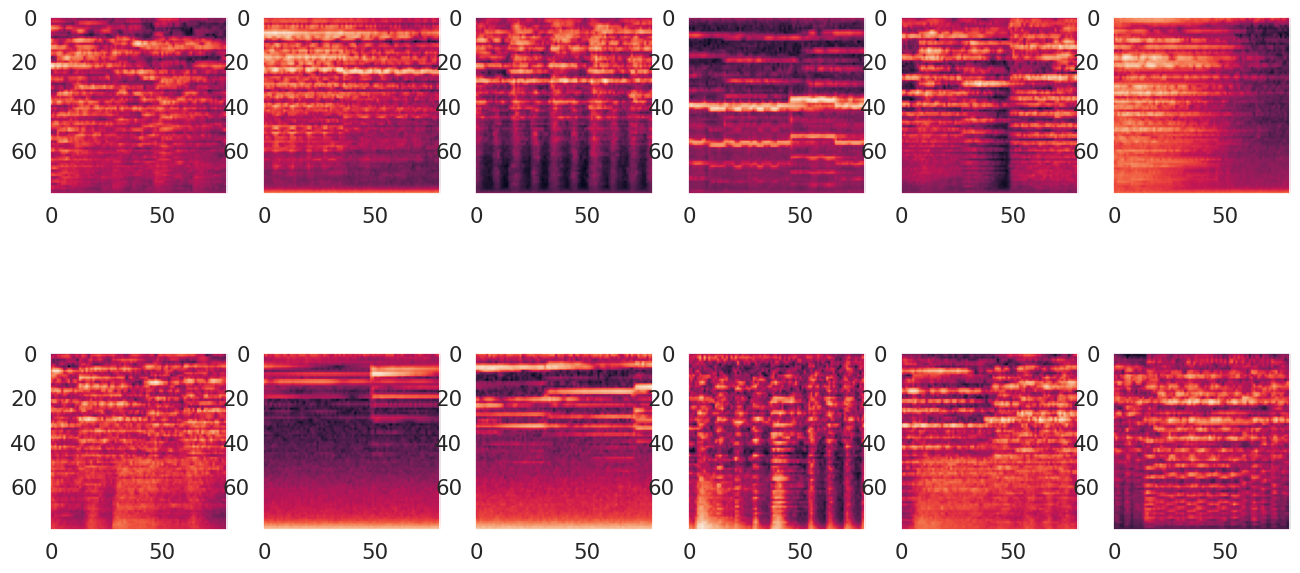

#### Class_______________________disco______________________________________________

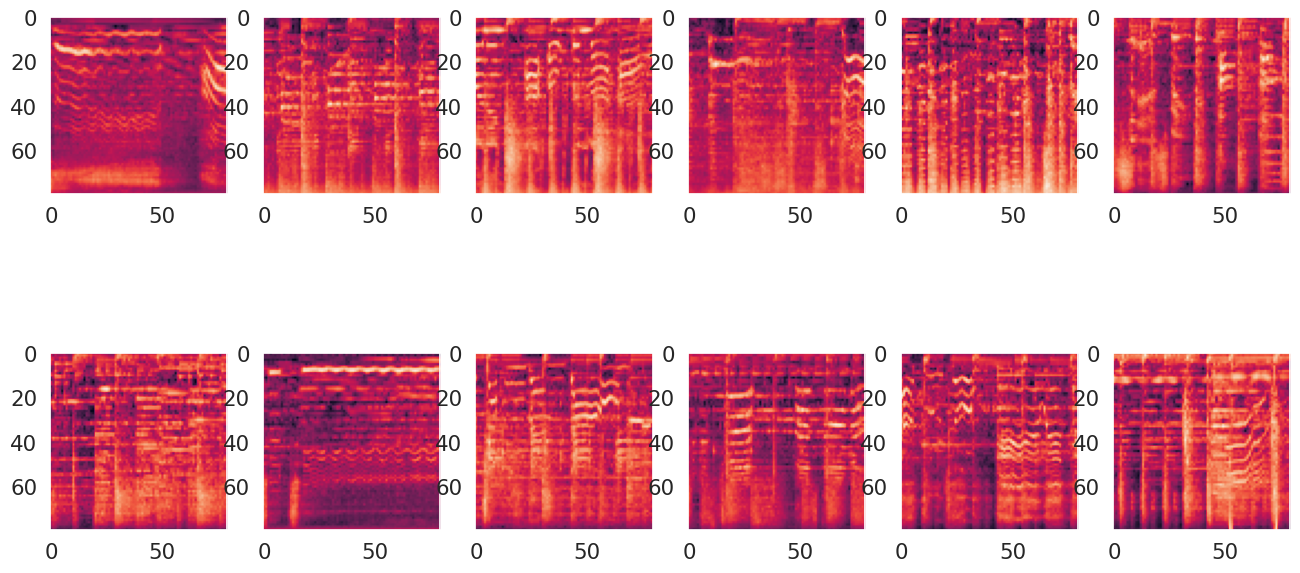

#### Class_______________________metal______________________________________________

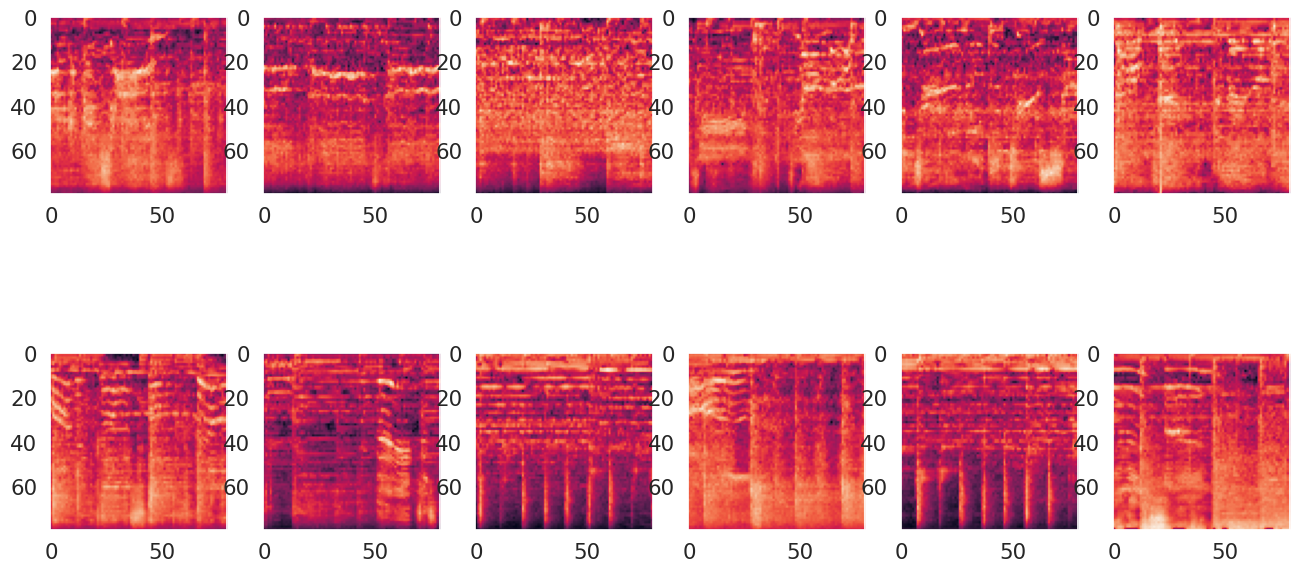

#### Class_______________________rock______________________________________________

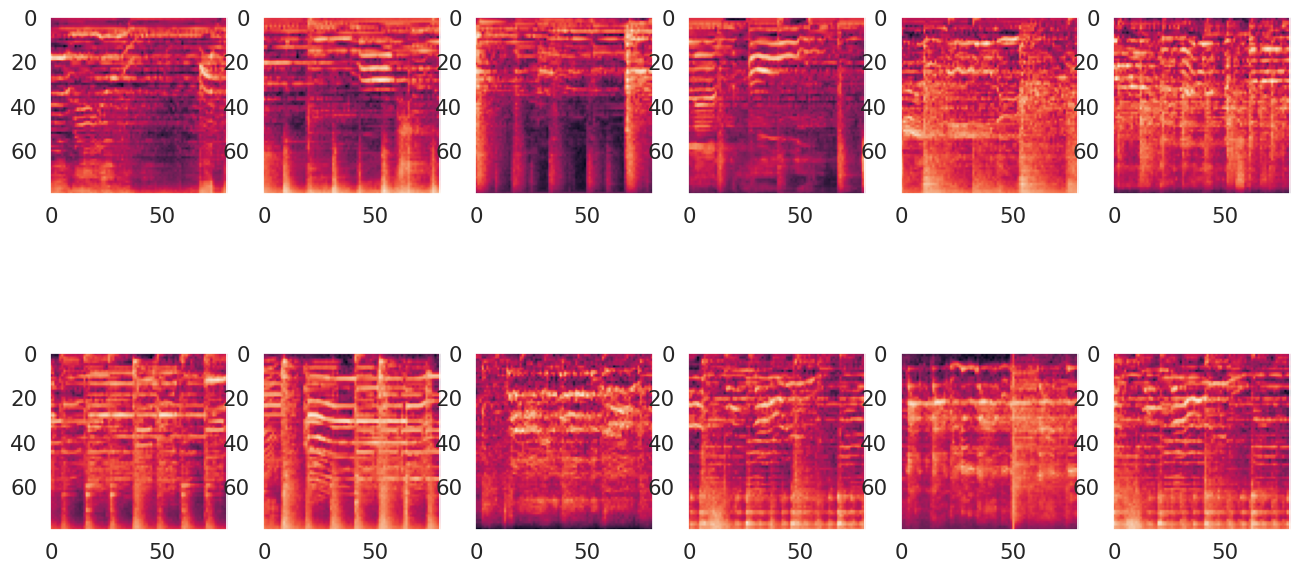

In [81]:
from IPython.display import display, Markdown

for i in [0,1,2,3]:
  #print('Class number___________________________________________', i)
  display(Markdown(f'#### Class_______________________{classes[i]}______________________________________________'))

  plot_spectrograms(2, 6, x_train, np.append(results[f'pred_{i}_correct'][:6], results[f'pred_{i}_incorrect'][:6]))
  plt.show()



**Do you observe some differences among music genres?**

1.   CLassical

The pictures are quite smooth, with a stable distribution throughout the time and frequence (as in music we don't usually hear unexpected bass or any other random instrument out of a sudden). Bright spots around the aquares might illustrate the large number of musical instruments involved. As I see it, when you hear classical music - it's usually sounds harmonic but you know that a lot of instruments are simultaneously making this sound. Horizontal bands might be an evidence of long harmonic episodes


2.   Disco

Regular lines at different frequences (horizontal) might describe the disco beats. It is rhytmic genre and the rhythm corresponds to this lines. Also, some patterns are very regular, which should be representation of that famous kick drum. Repeated patterns show that the nature of disco music is quite repetetive.

3. Metal

Metal can be charactarized as a fast genre, so i think that in terms of spectograms, they should depict tightly spaced vertical lines, expecially in lower frequency space - for drums. Also, the xtra consistent pattern that I can see is I think describes the bass - which is fast but heavy, so it's somewhere in the middle of the square.

 **BUT if the metal track has a quiet and melodic episode in music (which hapens!!), it can be classified incorrectly!!**

4. Rock

Rock is also a genre when dynamic music may be connected with quiet parts, which might be difficult to classify OR this might become a reason why other genres would be identified as rock even if they are not. So the parts of spectograms might be sparse but others quite dense. Nevertheless, there should be balance between drums, guitars and vocals. The energy is uniformly high, rhythm is intense, but there is a clear segmentation as I see it - that shows that at this point instruments dominate - at this point voice dominates.

**Conclusion** Classical should be the easiest to identify, disco samples should be described with some features finding the genre rhythmic, but rock is the herdest because it has the features of all genres to some point.

In [82]:
for i in [0, 1,2,3]:
  print_wrong_prediction(model, x_train, y_train, results[f'pred_{i}_incorrect'][:6], i, classes)


Wrongly predicted points for true class classical
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is disco
predicted class is rock
predicted class is disco
Wrongly predicted points for true class disco
predicted class is rock
predicted class is rock
predicted class is metal
predicted class is rock
predicted class is rock
predicted class is rock
Wrongly predicted points for true class metal
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
Wrongly predicted points for true class rock
predicted class is disco
predicted class is disco
predicted class is metal
predicted class is disco
predicted class is disco
predicted class is disco


**As I have said earlier, rock contains patterns of different genres, so that when the genre is missclassified - it's because the model was not that specific to understand that it's a certain type of genre, rather then rock, where all the patterns can be found. So this means that the model is rather not complex and sticks to easy decisions!**

In [83]:
for layer in model.layers:
    print(layer.name)

conv2d_56
max_pooling2d_61
conv2d_57
max_pooling2d_62
conv2d_58
max_pooling2d_63
flatten_7
dense_14
dense_15


#### Class_classical____________________________________________________________

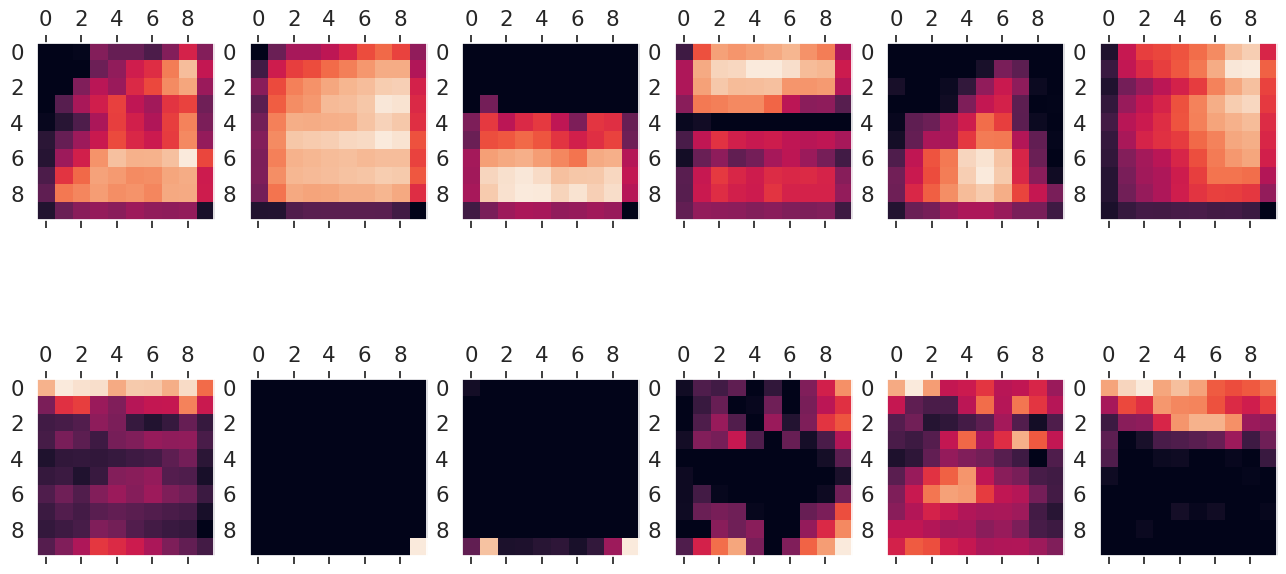

#### Class_disco____________________________________________________________

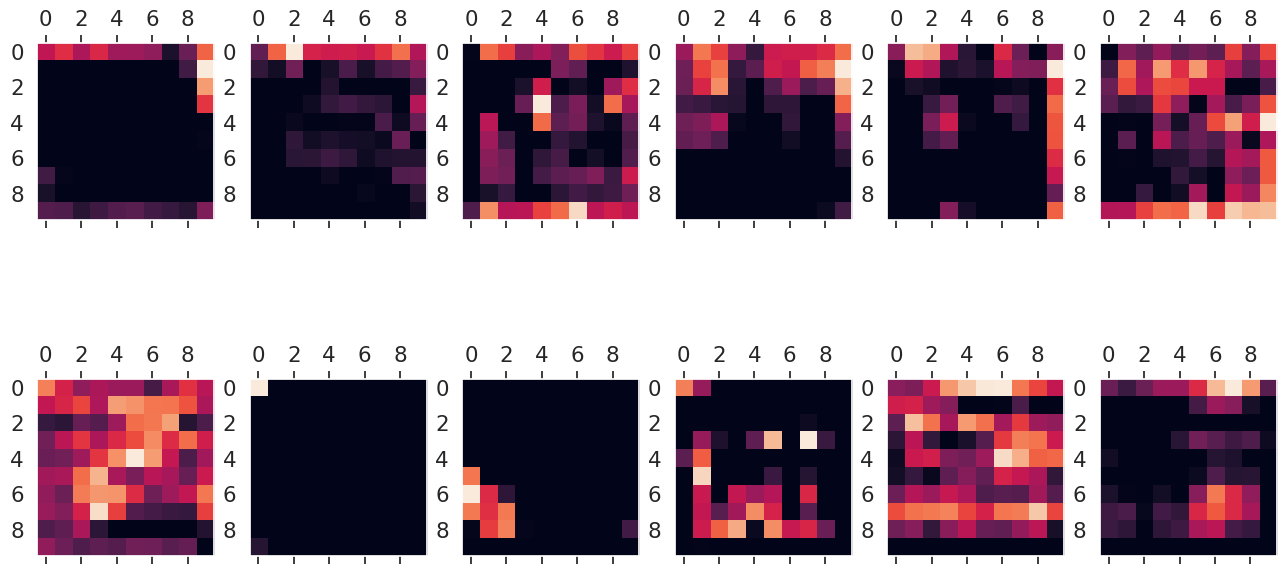

#### Class_metal____________________________________________________________

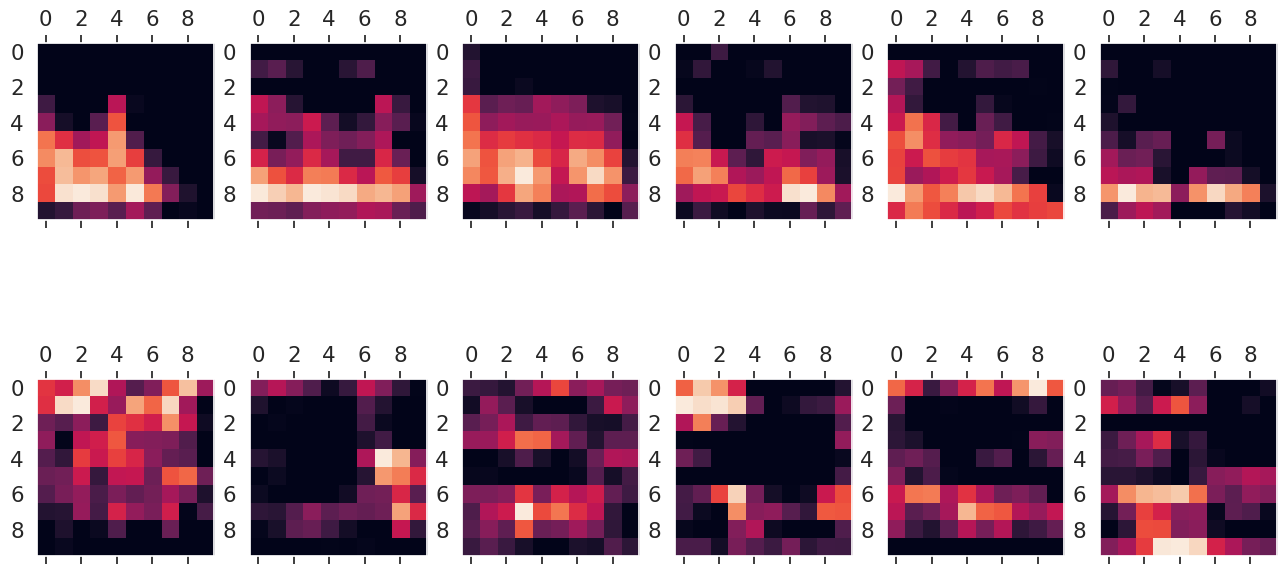

#### Class_rock____________________________________________________________

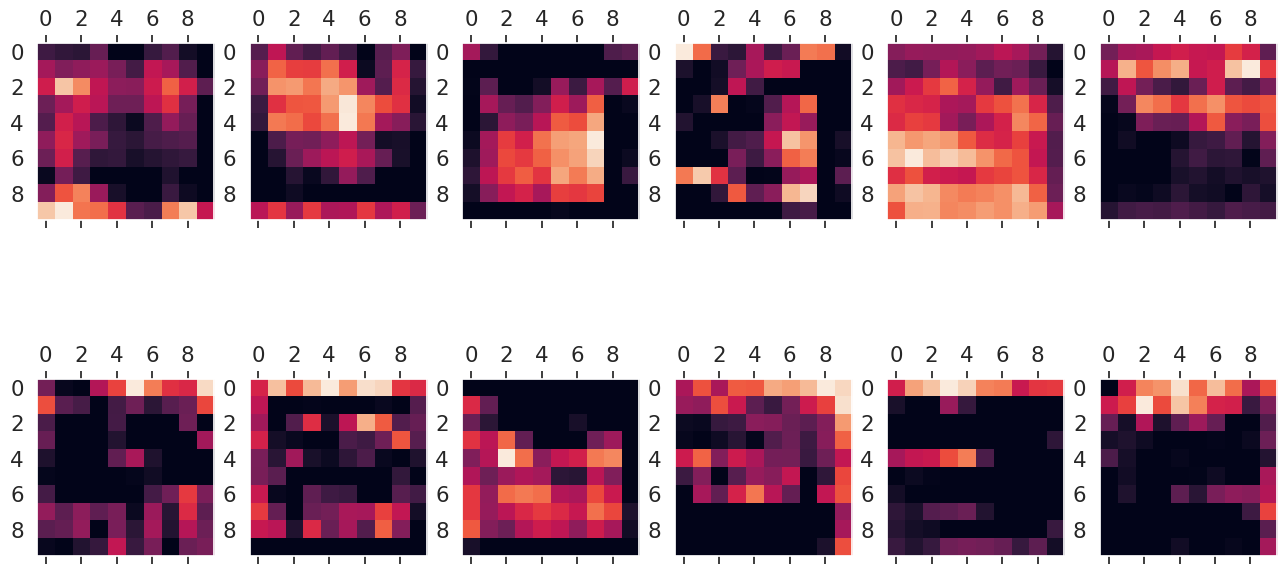

In [84]:
#the heatmaps of the last pooling layer for the same 12 extracts (6 correct + 6 wrong)
for i in [0,1,2,3]:
    display(Markdown(f'#### Class_{classes[i]}____________________________________________________________'))
    plot_gradcam_spectrogram(2, 6, x_train, np.append(results[f'pred_{i}_correct'][:6],results[f'pred_{i}_incorrect'][:6]),model = model, layer_name = 'max_pooling2d_63' )
    plt.show()



  **Classical**
  - The gradcam spectograms for classical music from the last pooling layer contain the gradient of the colours, the difference between the two neighbours in terms of colours is not big, there is a smooth transition from one square to another.
  - Furthermore, there is a certain pattern of frame along the contour, boundaring the content in the middle.
  - For the incorrectly classified objects: there is no contour, some of the squares depict black squares - I suppose the algorithm could not just speicufy to which class to classify this black square, so that it went to classical.
  - As I can see part of the correctly classified squares are partially black, because there is a transition from brighter colour to darker colour.
  -  And that is why part of the square may be totally dark, which may lead to misclassification for those squares which are fully black but not necessarily classic. In addition: the incorrectly classified objects are less harmonic, represent quite random pattern, no gradient, more distorted than the correct ones.

**Disco**

  - Correctly identified objects have either black and dark squares mostly OR super chaotic and randomly coloured neighbour squares.Also, some of the correctly identified objects represent the grad cam spectograms plots for the last pooling layer such that there is at least one of the sides of the counter (boundaries) is coloured. For instance, the first two in the row represent the first row from top coloured.
  -  On the other hand, the incorrectly classified disco objects also contain partially black plots, though they don't have this counter (boundary) thing - there is almost totally black plot except for several squares coloured.
  - The plots that contain chaoric randomly coloured squares are more bright in INCORRECTLY classified objects than they are in CORRECTLY classified ones.

**Metal**
  - Correctly classified ones have the black parts of the plots to the top, while the lightest ones to the bottom. The correct plots depict "gradient", less smooth than in classical music plots, and vertical, not horizontal.
  - For incorrectly classified objects - there is no gradient ,there are some black holes in the plots (primarily in the middles or in the angles) which does not classify metal. The pattern is quite chaotic for misclassified objects.
  - I assume that  the model cannot identify this objects to a certain class because the pattern is quite chaotic and it tries to find something similar in metal. Even though there might be smooth vertical gradient in the correctly classified objects, the neighbouring vertical lines might be quite different in terms of patterns - so that the model find them chaotic rather than just several gradients contatenated line by line.

**Rock**
  - As for the rock genre - the plots contain certain mini-squares where the concentration of certain colour is higher than in other parts of the plot. Despite this, the rock objects contain gradient pattern as well as chaotic pattern as well as boundary (counter) coloured line pattern. It makes rock harder to distinguish from other genres as it containes a lot of patterns from other genres and no certain general pattern as I see it. That is why when I printed which class was entitled to those incorrectly classified from other 3 classes, usually it was rock. For disco, for classic, for metal, the incorrectly classified objects used to be classified as rock, though they were not rock at all.
  - This is certainly because the pattern is not that consistent.

# 6. - Comment on the previous question: what are your thoughts about the applicability of the Grad-CAM tool on these data?**

Grad-CAM highlists the most important parts for classification: at which time which frequency was the most valuable for prediction for each class - this gives an idea for a person, how the classes are different from one another. It is more useful especially if you do know how the spectograms are built. While working on this, I have read a couple of papers on how the music is described in terms of frequencies and times to plot it into spectogram, so that now it gives more sense.

Importantly, this technique can help us understand why the model decides this and that. As I see it at some point the model cannot make a complex linkage with certain patterns and cannot classify rock that good, which can be slightly seen at the grad-cam as it combines the patterns that are also looked for within other classes. I would rather say that this approach help you to get deeper inside the model, to understand whether it is really learning something, or doing some messy predictions.


# P2

*Inception-like idea*

I created the name for my approach - **NARROW-WIDE-MIDDLE**

#Architecture

Convolutional pair with different filter sizes: **two separate convolutional paths, each with different filter shapes, so that the network can simultaneously learn to identify important features along both the time and frequency axes of the spectrogram.**

**1.** The model creates two separate convolutional paths right after the input layer. One focuses on the time dimension (using a filter shape of (1, N)), and the other focuses on the frequency dimension (using a filter shape of (N, 1)). Not (N, N) filters because I want to treat frequency and time differently.

(N, 1) - spans multiple frequency bands while only covering a single time step

(1, N) - spans multiple time steps while only covering a single frequency band

**2.** As for N, I have decided to add again parallel approach and vary N so as to capture very deep details as well as long sequence patterns. That is why for the very first parallel iteration I woild use N = 2 and N = 16 - to capture either general pattern or very detailed. Even though 16 sound like enormous number - as the second parameter in filter pair is equal to 1 - the overparametrization problem is not a problem.

2 - sensitive to narrower frequency patterns
16 - identify rhythmic patterns that occur over time

- *I have tried running it in different parts of the architecture or even combining 4 parallel conv layers with N equal to other numbers, but the most efficient in terms of accuracy, ability to learn but not memorize and in terms of computational load was inserting other parallel convolutions later in architecture, dropping out some neurons before, because it allowed not to overfit to some detailed patterns.*

**3.** After combining the paths, the model applies additional convolutional layers. They find higher-level features from the combined time and frequency info i brought from previous levels.

**4.** Maxpooling

**5.** Dropout

**6.** Second inception-like block. The ideaa of this paralell layers in my head was created after I have read more about the inceptionv3. So in 1-2 steps I did N=2 and N=16 (I assumed that its better to use the powers of two everywhere). The idea of the width between 2 and 16 was in capturing different patterns. Now we want to be extra good at identification the overall patterns. That is why I suppose to check for the common size of N=4 and N=8. But the idea is the same - not to use square filters, but (1,N) and (N,1) - so that frequency and time could be chased separately.

Increasing the number of filters in successive layers allows the network to learn a more complex hierarchy of features. Starting with the power of 2 which is 64 and moving to a higher number like 128 allows to gradually move from learning simple to more complex features

A (3, 3) filter has a small receptive field, so captures local patterns. This size is a good trade-off between capturing enough spatial information to detect features like edges or textures and not being too large as to require more computational sources.

**Optimizer**
SGD  have slower convergence rates and with the same number of epochs shows worse quality. I experimented withsome optimizers like Adagrad and Adam and sticked to the Adam.

In [20]:
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

def create_parallel_cnn_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    #TWO________________________________________________________________________________
    # Time-focused path
    time_conv2 = layers.Conv2D(16, (1, 2), padding='same', activation='relu')(inputs)
    time_pool2 = layers.MaxPooling2D((2, 2))(time_conv2)

    # Frequency-focused path
    freq_conv2 = layers.Conv2D(16, (2, 1), padding='same', activation='relu')(inputs)
    freq_pool2 = layers.MaxPooling2D((2, 2))(freq_conv2)

    # Combining paths
    combined2 = layers.concatenate([time_pool2, freq_pool2], axis=-1)

    #THREE________________________________________________________________________________
    # Time-focused path
    time_conv3 = layers.Conv2D(16, (1, 16), padding='same', activation='relu')(inputs)
    time_pool3 = layers.MaxPooling2D((2, 2))(time_conv3)

    # Frequency-focused path
    freq_conv3 = layers.Conv2D(16, (16, 1), padding='same', activation='relu')(inputs)
    freq_pool3 = layers.MaxPooling2D((2, 2))(freq_conv3)

    # Combining paths
    combined3 = layers.concatenate([time_pool3, freq_pool3], axis=-1)

    combined = layers.concatenate([ combined2, combined3], axis=-1)

    # Additional Convolutional Layers
    conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(combined)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(pool2)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    drop1 = layers.Dropout(0.4)(pool3)

    #ONE________________________________________________________________________________
    # Time-focused path
    time_conv = layers.Conv2D(16, (1, 4), padding='same', activation='relu')(drop1)
    time_pool = layers.MaxPooling2D((2, 2))(time_conv)

    # Frequency-focused path
    freq_conv = layers.Conv2D(16, (4, 1), padding='same', activation='relu')(drop1)
    freq_pool = layers.MaxPooling2D((2, 2))(freq_conv)

    # Combining paths
    combined1 = layers.concatenate([time_pool, freq_pool], axis=-1)


   #FOUR________________________________________________________________________________
    # Time-focused path
    time_conv4 = layers.Conv2D(16, (1, 8), padding='same', activation='relu')(drop1)
    time_pool4 = layers.MaxPooling2D((2, 2))(time_conv4)

    # Frequency-focused path
    freq_conv4 = layers.Conv2D(16, (8, 1), padding='same', activation='relu')(drop1)
    freq_pool4 = layers.MaxPooling2D((2, 2))(freq_conv4)

    # Combining paths
    combined4 = layers.concatenate([time_pool4, freq_pool4], axis=-1)

    combined_1 = layers.concatenate([ combined1, combined4], axis=-1)

    pooled_end = layers.MaxPooling2D((2, 2))(combined_1)

    # Flattening and Dense Layers
    flat = layers.Flatten()(pooled_end)
    dense = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(flat)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(dense)

    # Model compilation
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Adjusted input shape to match the spectrograms
input_shape = (80, 80, 1)
num_classes = 4  # Adjust based on the actual number of genres you're working with

# Create and compile the model
model_extra = create_parallel_cnn_model(input_shape, num_classes)
model_extra.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d_40 (Conv2D)          (None, 80, 80, 16)           48        ['input_5[0][0]']             
                                                                                                  
 conv2d_41 (Conv2D)          (None, 80, 80, 16)           48        ['input_5[0][0]']             
                                                                                                  
 conv2d_42 (Conv2D)          (None, 80, 80, 16)           272       ['input_5[0][0]']             
                                                                                            

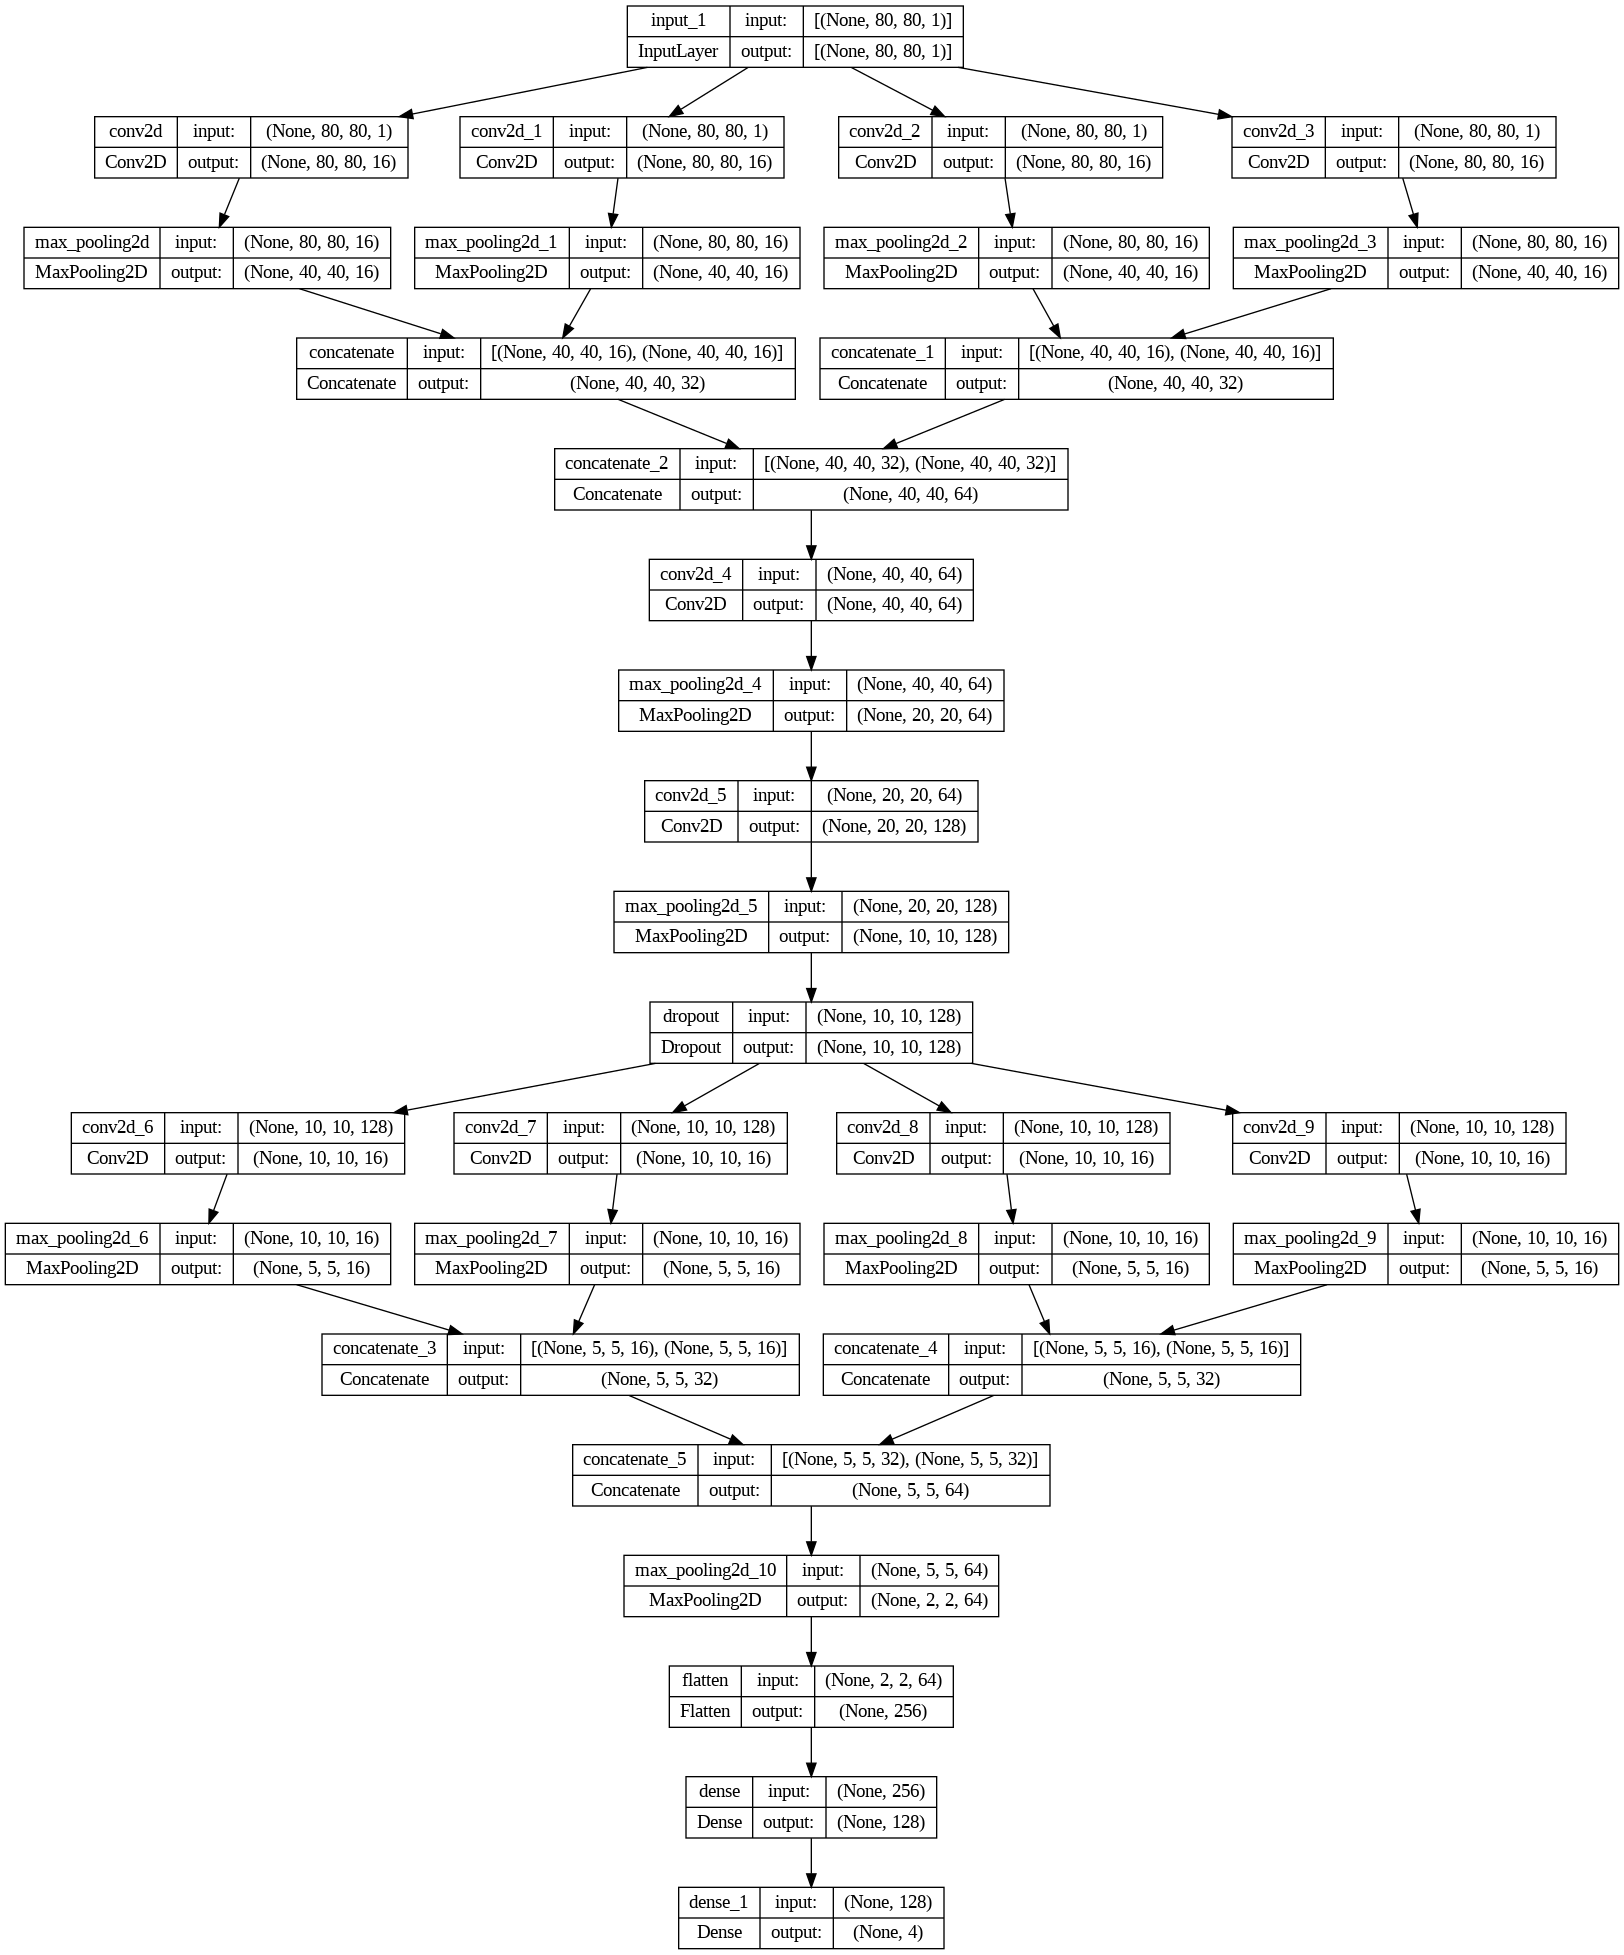

In [15]:
from tensorflow.keras.utils import plot_model

# After creating your model, you can plot the model like this:
plot_model(model_extra, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


I have decided to first train on a lower number of epochs, to see how it converges, assess how much time I will need and to assess how fast SGD and Adam work in comparison to each other

In [50]:
history_extra = model_extra.fit(x_train, y_train, epochs=12, batch_size=32, validation_data = (x_val, y_val))

Epoch 1/12
124/124 [==============================] - 117s 899ms/step - loss: 1.7540 - accuracy: 0.6504 - val_loss: 1.2347 - val_accuracy: 0.7284
Epoch 2/12
124/124 [==============================] - 111s 889ms/step - loss: 0.9643 - accuracy: 0.7752 - val_loss: 0.7986 - val_accuracy: 0.8251
Epoch 3/12
124/124 [==============================] - 105s 845ms/step - loss: 0.7064 - accuracy: 0.8255 - val_loss: 0.6500 - val_accuracy: 0.8262
Epoch 4/12
124/124 [==============================] - 109s 877ms/step - loss: 0.5252 - accuracy: 0.8570 - val_loss: 0.4920 - val_accuracy: 0.8619
Epoch 5/12
124/124 [==============================] - 109s 877ms/step - loss: 0.4387 - accuracy: 0.8765 - val_loss: 0.4228 - val_accuracy: 0.8872
Epoch 6/12
124/124 [==============================] - 103s 831ms/step - loss: 0.3728 - accuracy: 0.8904 - val_loss: 0.3770 - val_accuracy: 0.8964
Epoch 7/12
124/124 [==============================] - 107s 862ms/step - loss: 0.3157 - accuracy: 0.9078 - val_loss: 0.3418 -

In [51]:
# Test Accuracy when training with 20 epochs
score = model_extra.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]
print('Test accuracy %.2f%%' % accuracy)

Test accuracy 93.43%


Text(0.5, 0.98, 'Parallel identification of time and frequency')

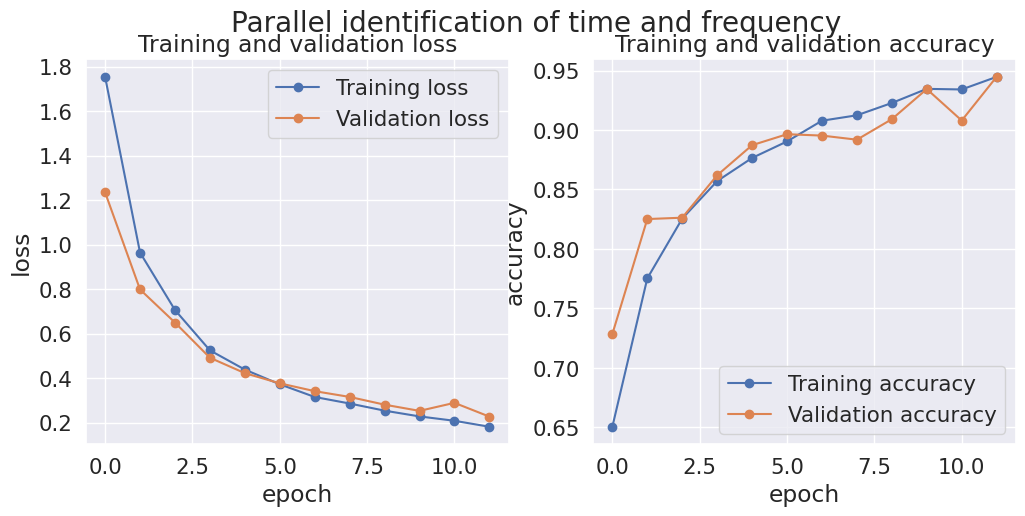

In [52]:
# Plot the loss function and the accuracy per epoch for the train and validation sets
# training and validation loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history_extra.history['loss'],'-o', label='Training loss')
ax1.plot(history_extra.history['val_loss'],'-o', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
ax2.plot(history_extra.history['accuracy'],'-o', label='Training accuracy')
ax2.plot(history_extra.history['val_accuracy'],'-o', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')
f.suptitle('Parallel identification of time and frequency')

124/124 [==============================] - 44s 343ms/step


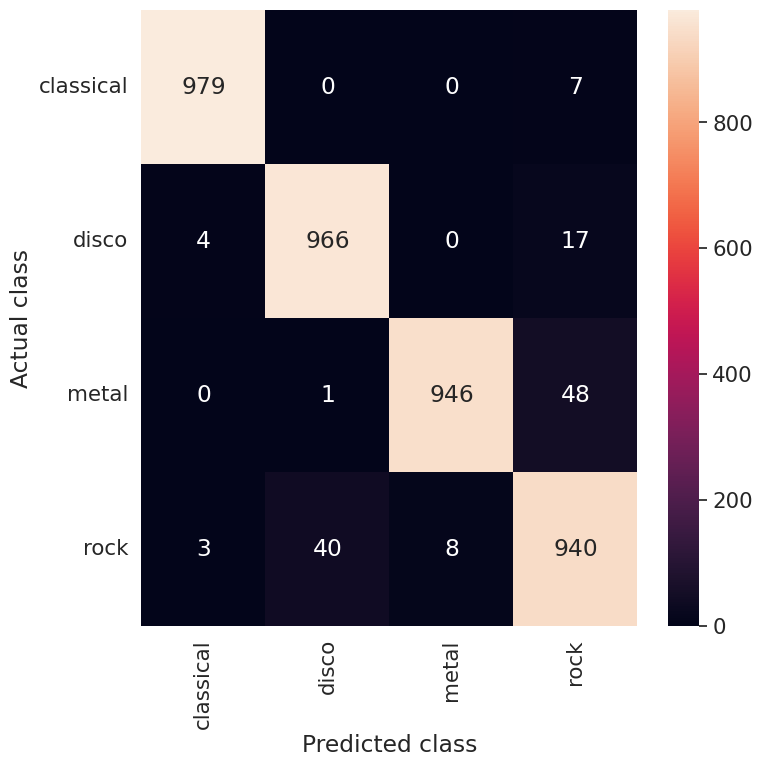

In [53]:
pred_extra = model_extra.predict(x_train)
plot_confusion_matrix(np.argmax(y_train, axis=1), np.argmax(pred_extra, axis=1) , classes)


37/37 [==============================] - 8s 215ms/step


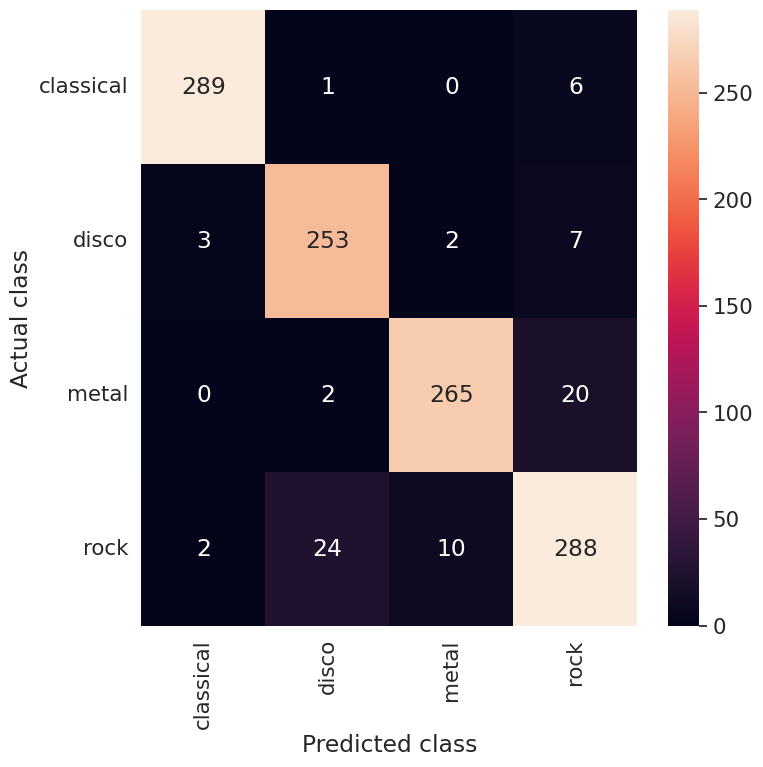

In [54]:
pred_extra_test = model_extra.predict(x_test)
plot_confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_extra_test, axis=1) , classes)


**Conclusion**: Rock is still the hardest genre to classify correctly and is been missclassified with disco and metal. But, despite this the confusion matrix for train and test set has higher numbers of correctly classified objects which is seen also by the overall accuracy.
I want to stress that in terms of FP and FN for rock genre the situation became better with the model architecture that I have proposed.

I have tried running the model with 20 epochs, where the accuracy after the 12 epoch might decrease, but in the end to the 20th epoch it becomes the biggest, which might depict the learning of some deep pattern to classify rock from other genres and making mistakes. Thus, the model trained through 20 epochs gives even better accuracy on test data - 94.45% instead of just 93.43%

If I look at the confusion matrix - in case of 20 epoch training, the model shows the amazing ability to predict rock class, though it sometimes missclassify it with metal, it seems more rational than when the previous model was telling that its the same as disco. Previous model (P1) was rather not thoroughly assessing rock features, just thinking that it is similar to contain all the other genres patterns. My current model captures the particularities of Rock!

The plots also allow to understand that the model learns well, because the loss is decreasing throughout the process for both the train and validation set! And the accuracy for validation set shows the growing pattern alongside the train set, which means that even having a lot of parameters in model, the parametrization was useful to capture the extraordinary patterns to classify genres.

### **Training with 20 epochs**

In [29]:
model_20 = create_parallel_cnn_model(input_shape, num_classes)
model_20.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d_50 (Conv2D)          (None, 80, 80, 16)           48        ['input_6[0][0]']             
                                                                                                  
 conv2d_51 (Conv2D)          (None, 80, 80, 16)           48        ['input_6[0][0]']             
                                                                                                  
 conv2d_52 (Conv2D)          (None, 80, 80, 16)           272       ['input_6[0][0]']             
                                                                                            

In [30]:
history_20 = model_20.fit(x_train, y_train, epochs=20, batch_size=32, validation_data = (x_val, y_val))

Epoch 1/20
124/124 [==============================] - 6s 26ms/step - loss: 1.7577 - accuracy: 0.6519 - val_loss: 1.2346 - val_accuracy: 0.7468
Epoch 2/20
124/124 [==============================] - 3s 22ms/step - loss: 0.9569 - accuracy: 0.7873 - val_loss: 0.7850 - val_accuracy: 0.8193
Epoch 3/20
124/124 [==============================] - 3s 23ms/step - loss: 0.6992 - accuracy: 0.8260 - val_loss: 0.6696 - val_accuracy: 0.8216
Epoch 4/20
124/124 [==============================] - 3s 21ms/step - loss: 0.5490 - accuracy: 0.8505 - val_loss: 0.5051 - val_accuracy: 0.8608
Epoch 5/20
124/124 [==============================] - 3s 22ms/step - loss: 0.4448 - accuracy: 0.8788 - val_loss: 0.4343 - val_accuracy: 0.8792
Epoch 6/20
124/124 [==============================] - 3s 23ms/step - loss: 0.3711 - accuracy: 0.8919 - val_loss: 0.3790 - val_accuracy: 0.8815
Epoch 7/20
124/124 [==============================] - 3s 24ms/step - loss: 0.3404 - accuracy: 0.8977 - val_loss: 0.3775 - val_accuracy: 0.8734

In [31]:
# Test Accuracy when training with 20 epochs
score_20 = model_20.evaluate(x_test, y_test, verbose=0)
accuracy_20 = 100*score_20[1]
print('Test accuracy %.2f%%' % accuracy_20)

Test accuracy 94.45%


Text(0.5, 0.98, 'Parallel identification of time and frequency')

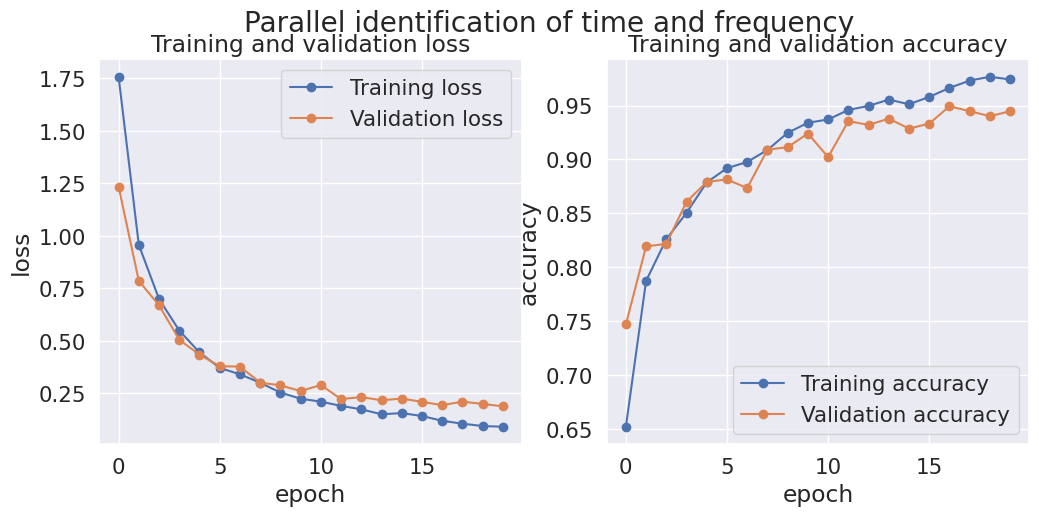

In [32]:
# Plot the loss function and the accuracy per epoch for the train and validation sets
# training and validation loss
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history_20.history['loss'],'-o', label='Training loss')
ax1.plot(history_20.history['val_loss'],'-o', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
ax2.plot(history_20.history['accuracy'],'-o', label='Training accuracy')
ax2.plot(history_20.history['val_accuracy'],'-o', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')
f.suptitle('Parallel identification of time and frequency')

124/124 [==============================] - 1s 6ms/step


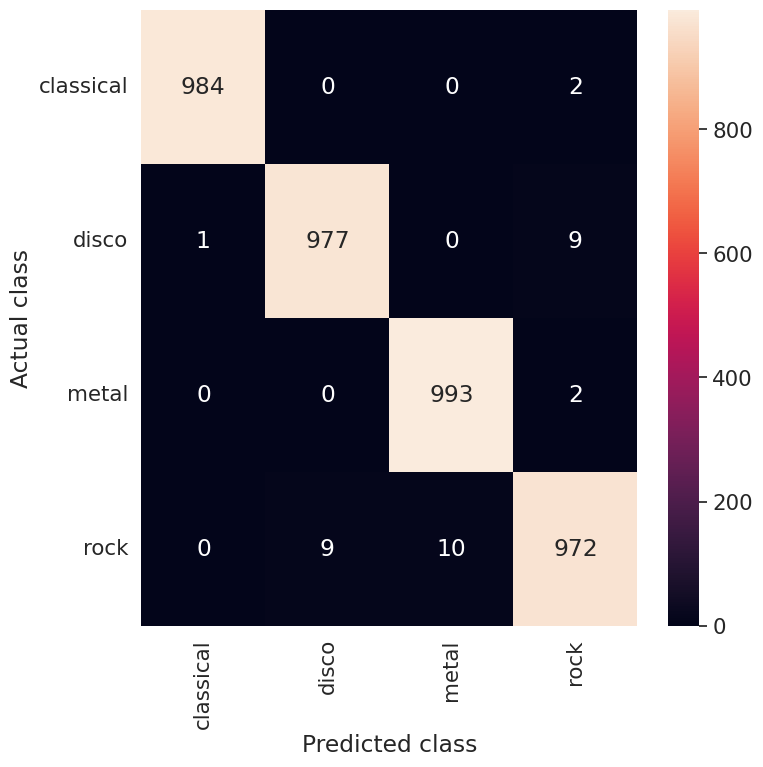

In [33]:
pred_train_20 = model_20.predict(x_train)
plot_confusion_matrix(np.argmax(y_train, axis=1), np.argmax(pred_train_20, axis=1) , classes)


37/37 [==============================] - 0s 6ms/step


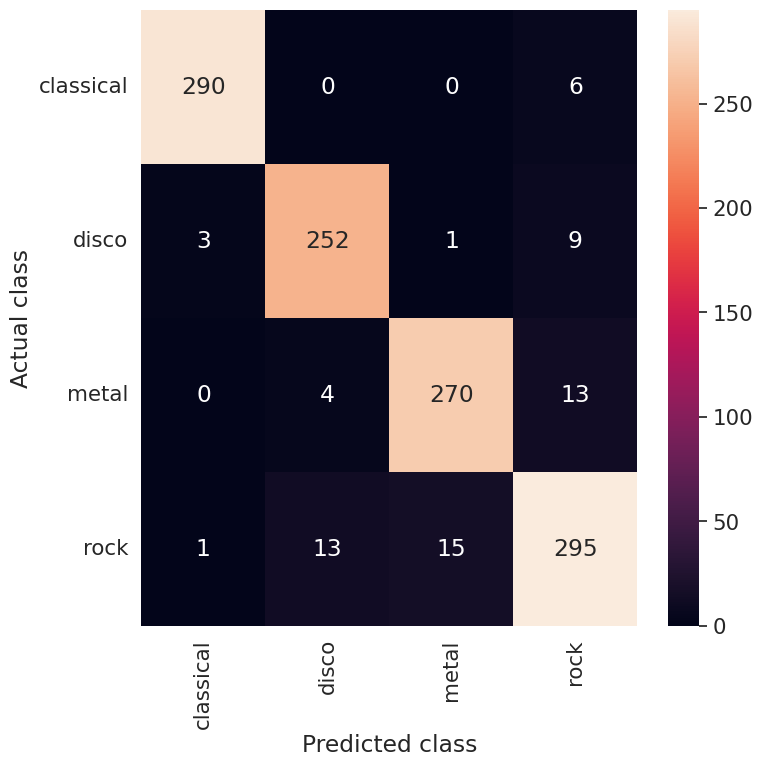

In [34]:
pred_test_20 = model_20.predict(x_test)
plot_confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_test_20, axis=1) , classes)
